In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
!pip install scikit-learn==1.2.2 imbalanced-learn==0.10.1 --quiet
from imblearn.over_sampling import SMOTE

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, f1_score, accuracy_score # Added accuracy_score import



sns.set(style='whitegrid')
plt.style.use('seaborn-v0_8-pastel')

---------- Tampilan 5 Data Teratas ----------
   Time_spent_Alone Stage_fear  Social_event_attendance  Going_outside  \
0               4.0         No                      4.0            6.0   
1               9.0        Yes                      0.0            0.0   
2               9.0        Yes                      1.0            2.0   
3               0.0         No                      6.0            7.0   
4               3.0         No                      9.0            4.0   

  Drained_after_socializing  Friends_circle_size  Post_frequency Personality  
0                        No                 13.0             5.0   Extrovert  
1                       Yes                  0.0             3.0   Introvert  
2                       Yes                  5.0             2.0   Introvert  
3                        No                 14.0             8.0   Extrovert  
4                        No                  8.0             5.0   Extrovert  


---------- Informasi Dasar Datase

/tmp/ipython-input-2-1248263717.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df['Personality'], order = df['Personality'].value_counts().index, palette='viridis')


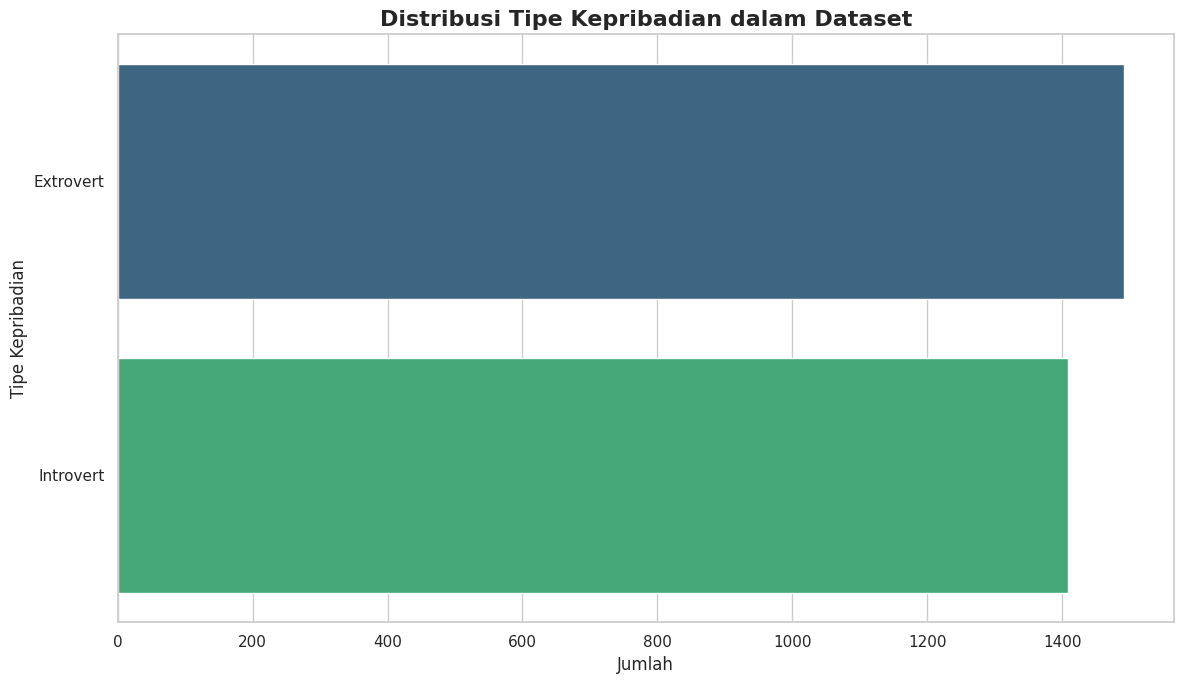

In [2]:
file_path = 'personality_datasert.csv'
try:
    df = pd.read_csv(file_path, encoding='utf-8')
except UnicodeDecodeError:
    df = pd.read_csv(file_path, encoding='latin1')

print("---------- Tampilan 5 Data Teratas ----------")
print(df.head())
print("\n" + "="*60 + "\n")

print("---------- Informasi Dasar Dataset ----------")
df.info()
print("\n" + "="*60 + "\n")

print("---------- Pengecekan Nilai yang Hilang (Missing Values) ----------")
print(df.isnull().sum())
print("\n" + "="*60 + "\n")

numeric_columns = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 'Friends_circle_size', 'Post_frequency']
categorical_columns = ['Stage_fear', 'Drained_after_socializing']
target_column = 'Personality'

for col in categorical_columns:
    print(f"\nUnique values in {col}:")
    print(df[col].value_counts(dropna=False))


# Visualisasi distribusi kelas target (Personality)

try:
    df = pd.read_csv(file_path, encoding='utf-8')
except UnicodeDecodeError:
    df = pd.read_csv(file_path, encoding='latin1')

plt.figure(figsize=(12, 7))
sns.countplot(y=df['Personality'], order = df['Personality'].value_counts().index, palette='viridis')
plt.title('Distribusi Tipe Kepribadian dalam Dataset', fontsize=16, fontweight='bold')
plt.xlabel('Jumlah', fontsize=12)
plt.ylabel('Tipe Kepribadian', fontsize=12)
plt.tight_layout()
plt.show()

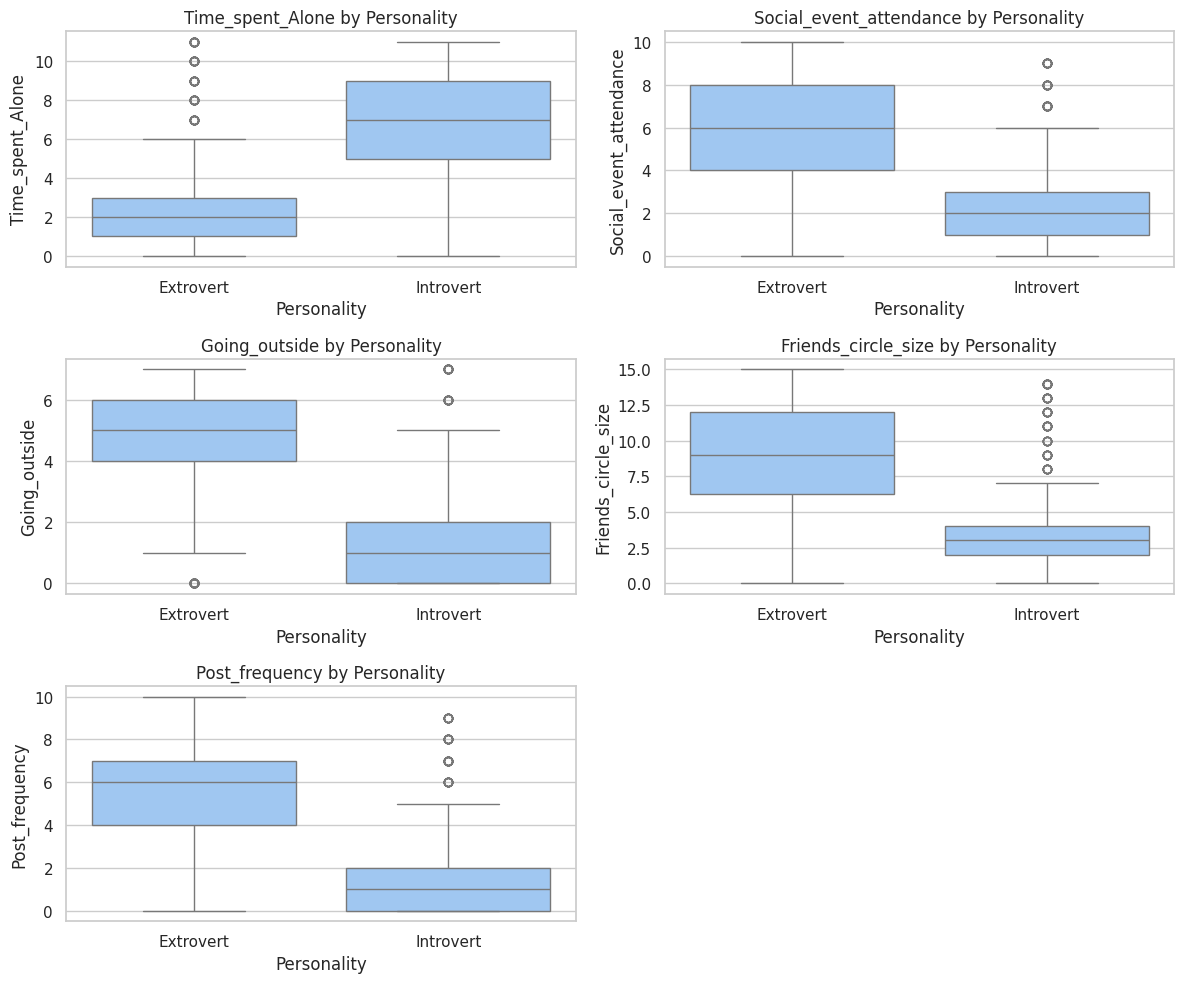

In [3]:
data = df
numeric_columns = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 'Friends_circle_size', 'Post_frequency'] # Define numeric_columns
target_column = 'Personality'

plt.figure(figsize=(12, 10))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(x=target_column, y=col, data=data)
    plt.title(f'{col} by Personality')
plt.tight_layout()
plt.show()

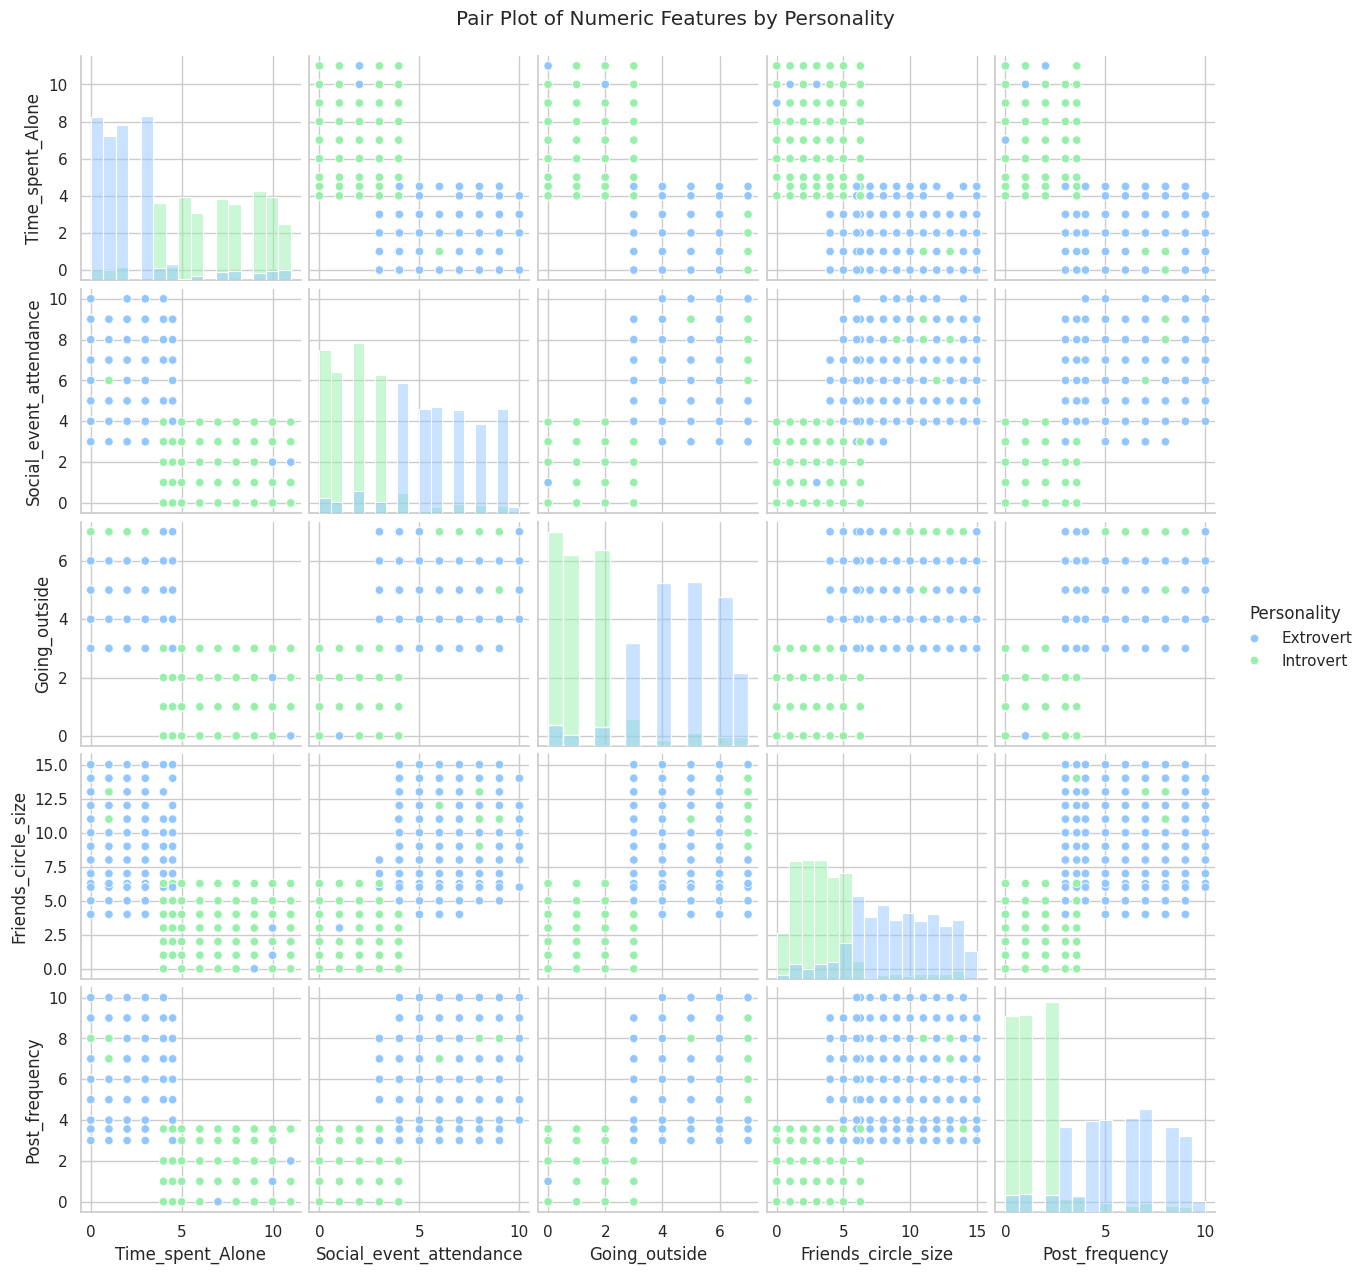

In [4]:
sns.pairplot(df[numeric_columns + [target_column]], hue=target_column, diag_kind='hist')
plt.suptitle('Pair Plot of Numeric Features by Personality', y=1.02)

plt.show()

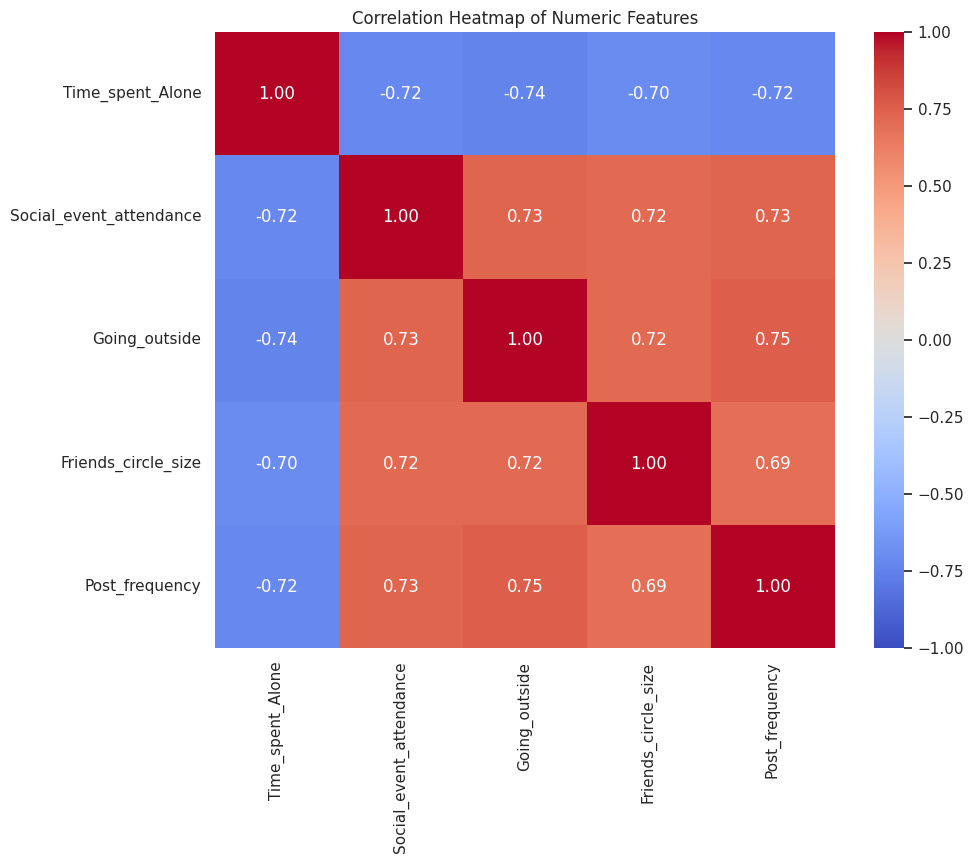

In [5]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[numeric_columns].corr(), annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

In [6]:

# Menggunakan Label Encoding untuk kolom kategorikal dan target
label_encoders = {}
for col in categorical_columns + [target_column]:
  le = LabelEncoder()
  df[col] = le.fit_transform(df[col])
  label_encoders[col] = le # Menyimpan encoder jika perlu di-inverse transform nanti

print("\n---------- Dataset setelah Label Encoding ----------")
print(df.head())
print("\n" + "="*60 + "\n")

# Memverifikasi encoding pada kolom kategorikal dan target
for col in categorical_columns + [target_column]:
  print(f"\nUnique encoded values in {col}:")
  print(df[col].value_counts(dropna=False))

# Handle missing values
numeric_imputer = SimpleImputer(strategy='median')
data[numeric_columns] = numeric_imputer.fit_transform(data[numeric_columns])



---------- Dataset setelah Label Encoding ----------
   Time_spent_Alone  Stage_fear  Social_event_attendance  Going_outside  \
0               4.0           0                      4.0            6.0   
1               9.0           1                      0.0            0.0   
2               9.0           1                      1.0            2.0   
3               0.0           0                      6.0            7.0   
4               3.0           0                      9.0            4.0   

   Drained_after_socializing  Friends_circle_size  Post_frequency  Personality  
0                          0                 13.0             5.0            0  
1                          1                  0.0             3.0            1  
2                          1                  5.0             2.0            1  
3                          0                 14.0             8.0            0  
4                          0                  8.0             5.0            0  



Unique

In [7]:
#Cap outliers instead of removing
for col in numeric_columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

In [8]:
# Assuming feature engineering has been applied to df
X = df.drop(columns=[target_column])
y = df[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(f"Jumlah data total     : {len(X)}")
print(f"Jumlah data training  : {len(X_train)}")
print(f"Jumlah data testing   : {len(X_test)}")

Jumlah data total     : 2900
Jumlah data training  : 2320
Jumlah data testing   : 580


In [9]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
# Apply SMOTE to the training data after feature engineering
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Scale features after SMOTE
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled) # Scale resampled training data
X_test_scaled = scaler.transform(X_test) # Scale original test data

In [10]:
# Create new features
# Apply feature engineering to resampled training data and original test data
X_train_resampled['Alone_to_Social_Ratio'] = X_train_resampled['Time_spent_Alone'] / (X_train_resampled['Social_event_attendance'] + 1)
X_test['Alone_to_Social_Ratio'] = X_test['Time_spent_Alone'] / (X_test['Social_event_attendance'] + 1)
X_train_resampled['Social_Comfort_Index'] = (X_train_resampled['Friends_circle_size'] + X_train_resampled['Post_frequency'] - X_train_resampled['Stage_fear']) / 3
X_test['Social_Comfort_Index'] = (X_test['Friends_circle_size'] + X_test['Post_frequency'] - X_test['Stage_fear']) / 3
X_train_resampled['Social_Overload'] = X_train_resampled['Drained_after_socializing'] * X_train_resampled['Social_event_attendance']
X_test['Social_Overload'] = X_test['Drained_after_socializing'] * X_test['Social_event_attendance']

# Binned features
# Ensure the columns for binning exist and are numeric
if 'Time_spent_Alone' in X_train_resampled.columns:
    X_train_resampled['Time_spent_Alone_Binned'] = pd.qcut(X_train_resampled['Time_spent_Alone'], q=3, labels=['Low', 'Medium', 'High'], duplicates='drop')
    X_train_resampled = pd.get_dummies(X_train_resampled, columns=['Time_spent_Alone_Binned'], prefix='Time_spent_Alone_Binned', drop_first=True)
if 'Time_spent_Alone' in X_test.columns:
     X_test['Time_spent_Alone_Binned'] = pd.qcut(X_test['Time_spent_Alone'], q=3, labels=['Low', 'Medium', 'High'], duplicates='drop')
     X_test = pd.get_dummies(X_test, columns=['Time_spent_Alone_Binned'], prefix='Time_spent_Alone_Binned', drop_first=True)


# Polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
# Ensure the columns for polynomial features exist
poly_cols = ['Time_spent_Alone', 'Social_event_attendance', 'Friends_circle_size']
existing_poly_cols_train = [col for col in poly_cols if col in X_train_resampled.columns]
existing_poly_cols_test = [col for col in poly_cols if col in X_test.columns]


if existing_poly_cols_train:
    poly_features_train = poly.fit_transform(X_train_resampled[existing_poly_cols_train])
    poly_feature_names = poly.get_feature_names_out(existing_poly_cols_train)
    # Ensure the number of generated features matches the column names
    if poly_features_train.shape[1] == len(poly_feature_names):
        X_train_resampled[poly_feature_names] = poly_features_train
    else:
        print("Warning: Mismatch between polynomial features and names for training data.")

if existing_poly_cols_test:
    poly_features_test = poly.transform(X_test[existing_poly_cols_test])
     # Ensure the number of generated features matches the column names
    if poly_features_test.shape[1] == len(poly_feature_names):
        X_test[poly_feature_names] = poly_features_test
    else:
        print("Warning: Mismatch between polynomial features and names for testing data.")


# Update scaled features
# Ensure X_train_scaled and X_test_scaled are updated after adding new features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled) # Scale resampled training data
X_test_scaled = scaler.transform(X_test) # Scale original test data

In [11]:
models = {
    'logistic': {
        'model': LogisticRegression(max_iter=1000),
        'use_scaled': True
    },
    'svm': {
        'model': SVC(probability=True),
        'use_scaled': True
    },
    'rf': {
        'model': RandomForestClassifier(random_state=42),
        'use_scaled': False
    },
    'gb': {
        'model': GradientBoostingClassifier(random_state=42),
        'use_scaled': False
    },
    'knn': {
        'model': KNeighborsClassifier(),
        'use_scaled': True
    },
    'dt': {
        'model': DecisionTreeClassifier(random_state=42),
        'use_scaled': False
    },
    'xgb': {
        'model': XGBClassifier(random_state=42, eval_metric='logloss'),
        'use_scaled': False
    }
}


In [12]:
results = []

for model_name, mp in models.items():
    model = mp['model']
    # Use scaled data for models that require it, and original resampled data otherwise
    X_used = X_train_scaled if mp['use_scaled'] else X_train_resampled
    y_used = y_train_resampled
    X_test_used = X_test_scaled if mp['use_scaled'] else X_test

    # Ensure column names are consistent for models that don't use scaled data
    if not mp['use_scaled']:
        X_test_used = X_test_used[X_used.columns]


    model.fit(X_used, y_used)
    y_pred = model.predict(X_test_used)

    acc = accuracy_score(y_test, y_pred)
    print(f"Model: {model_name}")
    print(f"Akurasi: {acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=label_encoders['Personality'].classes_))
    print("="*60)

    results.append({
        'model': model_name,
        'accuracy': acc
    })

Model: logistic
Akurasi: 0.9069
              precision    recall  f1-score   support

   Extrovert       0.92      0.90      0.91       298
   Introvert       0.89      0.92      0.91       282

    accuracy                           0.91       580
   macro avg       0.91      0.91      0.91       580
weighted avg       0.91      0.91      0.91       580

Model: svm
Akurasi: 0.9172
              precision    recall  f1-score   support

   Extrovert       0.94      0.90      0.92       298
   Introvert       0.90      0.94      0.92       282

    accuracy                           0.92       580
   macro avg       0.92      0.92      0.92       580
weighted avg       0.92      0.92      0.92       580

Model: rf
Akurasi: 0.8914
              precision    recall  f1-score   support

   Extrovert       0.91      0.88      0.89       298
   Introvert       0.88      0.90      0.89       282

    accuracy                           0.89       580
   macro avg       0.89      0.89      0.89

In [13]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Base learners (level-0 models)
base_learners = [
    ('dt', DecisionTreeClassifier(max_depth=5, random_state=42)),
    ('svm', SVC(probability=True, kernel='rbf', C=1)),
    ('knn', KNeighborsClassifier(n_neighbors=5))
]

# Meta-learner (level-1 model)
meta_learner = LogisticRegression(max_iter=1000)

# Buat stacking classifier
stacking_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=5,
    n_jobs=-1,
    passthrough=False
)

# Train stacking classifier on scaled and resampled training data
stacking_model.fit(X_train_scaled, y_train_resampled)

StackingClassifier(cv=5,
                   estimators=[('dt',
                                DecisionTreeClassifier(max_depth=5,
                                                       random_state=42)),
                               ('svm', SVC(C=1, probability=True)),
                               ('knn', KNeighborsClassifier())],
                   final_estimator=LogisticRegression(max_iter=1000),
                   n_jobs=-1)

Hasil Evaluasi Stacking Classifier
Akurasi: 0.9172
Classification Report:
              precision    recall  f1-score   support

   Extrovert       0.94      0.90      0.92       298
   Introvert       0.90      0.94      0.92       282

    accuracy                           0.92       580
   macro avg       0.92      0.92      0.92       580
weighted avg       0.92      0.92      0.92       580



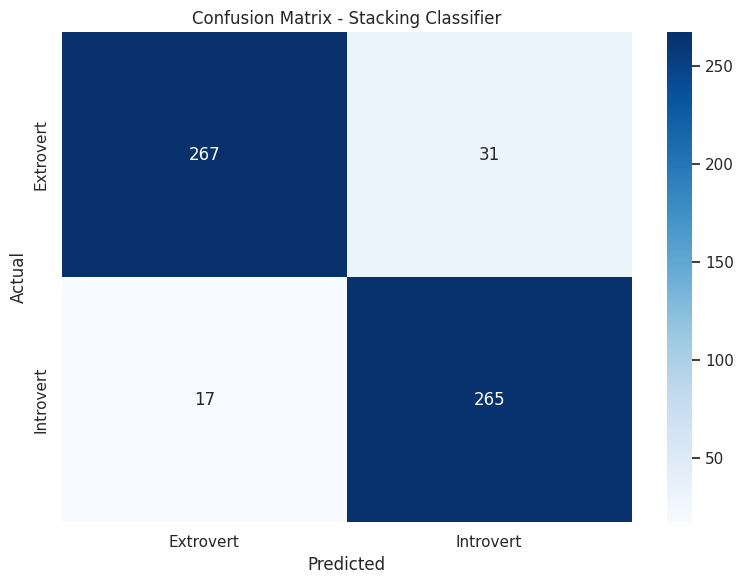

In [14]:
# Prediksi di test set using the scaled test data
y_pred_stack = stacking_model.predict(X_test_scaled)

# Akurasi dan laporan klasifikasi
print("Hasil Evaluasi Stacking Classifier")
print(f"Akurasi: {accuracy_score(y_test, y_pred_stack):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_stack, target_names=label_encoders['Personality'].classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_stack)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoders['Personality'].classes_,
            yticklabels=label_encoders['Personality'].classes_)
plt.title("Confusion Matrix - Stacking Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

/tmp/ipython-input-15-2852161584.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='accuracy', y='model', palette='viridis')


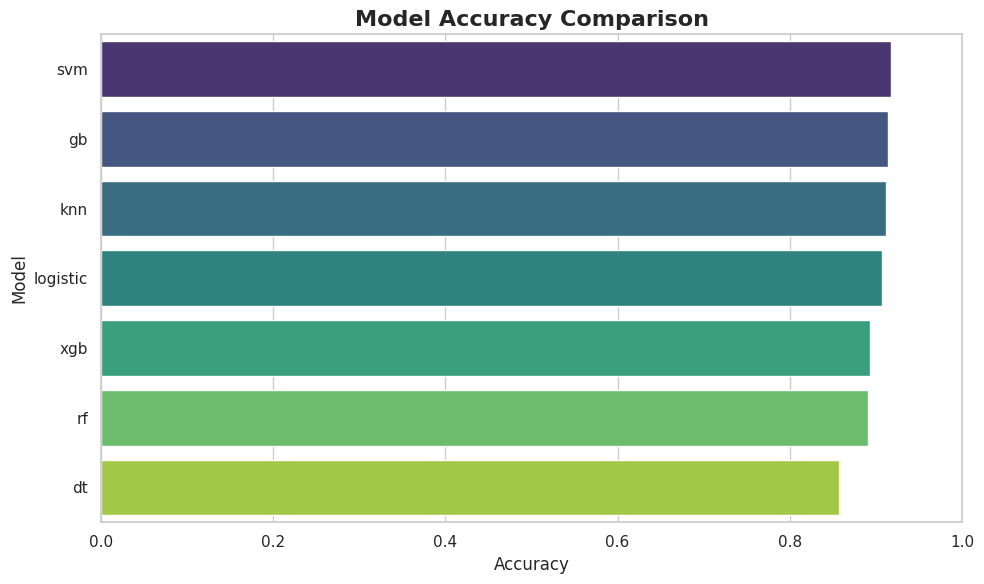

In [15]:
results_df = pd.DataFrame(results)  # List of {'model': ..., 'accuracy': ...}
results_df.sort_values(by='accuracy', ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x='accuracy', y='model', palette='viridis')
plt.title("Model Accuracy Comparison", fontsize=16, fontweight='bold')
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.xlim(0, 1)
plt.grid(True, axis='x')
plt.tight_layout()
plt.savefig("img/model_accuracy_comparison.png")
plt.show()
